Saving B!.jpg to B!.jpg


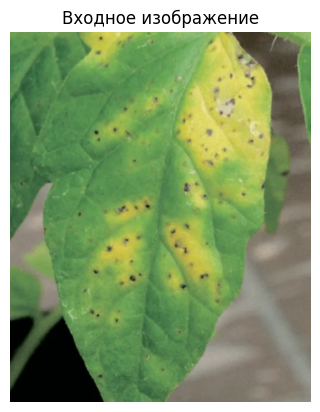

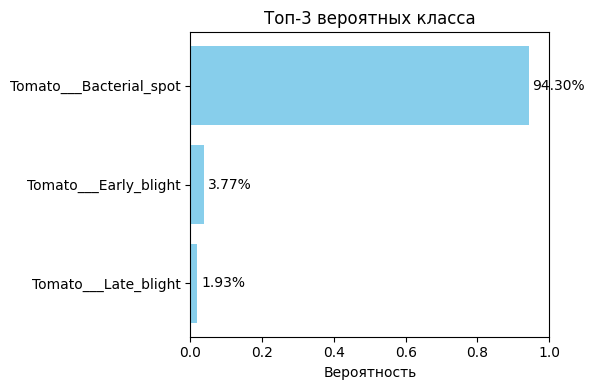

In [2]:
# ------------------------------
# 1. Импорты и конфигурация
# ------------------------------
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import requests
from io import BytesIO
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np

# Устройство
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224

# Классы болезней
class_names = [
    'Tomato___Target_Spot',
    'Tomato___healthy',
    'Tomato___Early_blight',
    'Tomato___Bacterial_spot',
    'Tomato___Late_blight',
    'Tomato___Leaf_Mold'
]
NUM_CLASSES = len(class_names)

# ------------------------------
# 2. Загрузка модели
# ------------------------------
def load_model(weights_path):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    model.classifier[1] = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(1280, NUM_CLASSES)
    )
    model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
    model.eval()
    return model.to(DEVICE)

# Загрузите модель (best_model.pth должен быть заранее загружен)
model = load_model("best_model.pth")

# ------------------------------
# 3. Трансформация и предсказание
# ------------------------------
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def predict_image(image: Image.Image):
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.softmax(output[0], dim=0).cpu().numpy()

    return probabilities

# ------------------------------
# 4. Предсказание с локального файла
# ------------------------------
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
img = Image.open(img_path).convert("RGB")

# ------------------------------
# 5. Обработка и вывод результатов
# ------------------------------
# Получаем вероятности
probs = predict_image(img)
top_prob = np.max(probs) * 100  # Вероятность топ-1 класса в процентах

# Проверка точности
if top_prob < 85:
    # Показ изображения с предупреждением
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Низкая уверенность модели ({}%)\nЗагрузите пожалуйста другое изображение".format(round(top_prob, 2)),
              color='red', fontsize=12)
    plt.show()
else:
    # Показ изображения
    plt.imshow(img)
    plt.axis('off')
    plt.title("Входное изображение")
    plt.show()

    # Получаем индексы топ-3 классов
    top3_idx = np.argsort(probs)[-3:][::-1]
    top3_probs = probs[top3_idx]
    top3_classes = [class_names[i] for i in top3_idx]

    # График
    plt.figure(figsize=(6, 4))
    bars = plt.barh(range(3), top3_probs[::-1], color='skyblue')
    plt.yticks(range(3), top3_classes[::-1])
    plt.xlabel('Вероятность')
    plt.title('Топ-3 вероятных класса')

    # Добавим значения на столбики
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                 f"{top3_probs[::-1][i]*100:.2f}%", va='center')

    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

    # Кнопка для скачивания рекомендаций
    from IPython.display import display, HTML
    pdf_link = "https://github.com/KateFarafoshina/Tomatoes/blob/main/tomato_disease_treatment_guide.pdf"

    display(HTML(f'''
        <a href="{pdf_link}" target="_blank">
            <button style="
                background-color: #4CAF50;
                border: none;
                color: white;
                padding: 10px 20px;
                text-align: center;
                text-decoration: none;
                font-size: 16px;
                border-radius: 5px;
                cursor: pointer;
            ">
                📥 Скачать рекомендации по лечению (PDF)
            </button>
        </a>
    '''))